# TP6 - Entrainement Vision Transformer (ViT)

## Introduction

Dans le TP précédent vous avez pu concevoir étape par étape le réseau ViT à l'aide de PyTorch, il est à présent temps de l'entrainer ! L'objectif du réseau va être de reconnaitre des chiffres du dataset MNIST (l'image utilisée dans les TP4 et TP5 était tirée de ce jeu de données !). **Pensez à utiliser la documentation PyTorch en parallèle des exercices !**

In [ ]:
import torch # https://pytorch.org/docs/stable/index.html
import torchvision # https://pytorch.org/vision/stable/index.html

Il est en général bien plus rapide d'entrainer un modèle sur GPU (`cuda`) plutôt que sur CPU. Le code suivant va automatiquement choisir quel processeur sera utilisé, selon la présence d'une carte graphique dans votre PC et votre installation PyTorch. Plus tard, plusieurs appels à `.to(device)` seront effectués afin de placer les données et le modèle sur le bon processeur.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Exercices

Cette fois-ci, plutôt que de charger une seule image, nous allons utiliser l'ensemble du jeu de données (plus vous avez de données, meilleur sera votre réseau !). Certains *datasets* très connus et utilisés en *Machine Learning* sont directement disponibles à partir de la bibliothèque `torchvision` (liste de l'ensemble des *datasets* disponibles : https://pytorch.org/vision/0.15/datasets.html). C'est le cas de MNIST sur lequel le réseau va ici être entrainé : https://pytorch.org/vision/0.15/generated/torchvision.datasets.MNIST.html

**Exercice 1 :** Avant de télécharger le jeu de données, créez une composition de transformations (`torchvision.transforms.Compose`) avec `transforms.ToTensor` et `transforms.Normalize` (on fixe la moyenne et l'écart type à `0.5`), puis stockez le résultat dans la variable `transform`.

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean=0.5, std=0.5)])
print(transform)

Compose(
    ToTensor()
    Normalize(mean=0.5, std=0.5)
)


In [ ]:
# transform =
# print(transform)

Ces transformations vont tout simplement permettre de transformer automatiquement les images en tenseurs, et de normaliser les valeurs à une même échelle afin d'améliorer la performance finale du réseau. Il s'agit d'une étape de pré-traitement (*preprocessing*) des données classique en *Machine Learning*.

Il est désormais possible de télécharger le *dataset* MNIST et d'y appliquer les transformations choisies. Notez bien qu'ici nous n'avons pas 1 mais 2 jeux de données : `train_dataset` et `test_dataset`.
- Le premier est celui sur lequel le réseau va être entrainé et donc apprendre à reconnaitre les chiffres.
- Le deuxième, qui ne contient **AUCUN** élément en commun avec le premier, est celui sur lequel le réseau va être testé en dehors de la phase d'entrainement. Ce 2e *dataset* est primordial afin de s'assurer que le réseau n'a pas appris par coeur les images de `train_dataset`, et parvient donc à généraliser la classification à n'importe quelle image de chiffre MNIST.

Si nous utilisions des données "non officielles" (par exemple un dossier contenant des milliers d'images) il aurait fallu s'arranger pour les répartir à la main en 2 jeux de données distincts. Mais ici, l'utilisation d'un jeu de données disponible dans `torchvision` permet de faciliter les choses, car il suffit de fixer le paramètre `train` à `True` pour le jeu d'entrainement, et à `False` pour le jeu de test. Notez que le nombre d'images pour l'entrainement est largement supérieur à celui pour la partie test (en général une répartition ~ 80% / 20% est préconisée).

In [ ]:
# Le dataset devrait automatiquement se télécharger en local dans un dossier ./data/
train_dataset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('./data/', download=True, train=False, transform=transform)
print('Number of train images:', len(train_dataset))
print('Number of test images:', len(test_dataset))

100%|██████████| 9912422/9912422 [00:00<00:00, 81618624.72it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 116030358.07it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27076334.05it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17055083.95it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Number of train images: 60000
Number of test images: 10000


L'objectif est que le réseau puisse voir toutes les images, et ce à de multiples reprises lors de l'entrainement. Il est cependant impossible (entre autres en raison de la puissance de calcul des PC actuels) de donner les 60000 images en une seule fois. Il est par conséquent important de pouvoir itérer sur les données de manière optimisée par petits morceaux (des *batchs*) et de façon aléatoire (on ne veut pas toujours montrer les images dans le même ordre). Pour répondre à cette problématique on utilise un `DataLoader` (https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

**Exercice 2 :** Créez un `DataLoader` pour le jeu de données d'entrainement, et un autre pour le jeu de données de test. Fixez la taille de *batch* à 32 (le réseau va recevoir 32 images à la fois), et activez le mélange des données (`shuffle`) pour le jeu de données d'entrainement. Stockez le résultat dans les variables `train_dataloader` et `test_dataloader`.

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
print(train_dataloader)
print(test_dataloader)

In [ ]:
# train_dataloader =
# test_dataloader =
# print(train_dataloader)
# print(test_dataloader)

Si l'on charge à présent un batch d'exemple, on remarque que chaque donnée contient 2 éléments.

In [ ]:
examples = enumerate(test_dataloader)
batch_idx, data = next(examples)
print(len(data))

2


La première partie correspond à notre batch d'images.

In [ ]:
print('Images:', data[0].shape)
b, c, h, w = data[0].shape
print('Batch(s):', b) # 32 images traitées à la fois
print('Channel(s):', c) # 1 seul canal de couleur car c'est une image en noir et blanc (3 canaux si c'était une image RGB)
print('Height:', h) # 28 pixels de hauteur
print('Width:', w) # 28 pixels de largeur

Images: torch.Size([32, 1, 28, 28])
Batch(s): 32
Channel(s): 1
Height: 28
Width: 28


La deuxième partie correspond à notre batch de labels, c'est-à-dire le chiffre à reconnaitre pour chaque image !

In [ ]:
print('Labels:', data[1].shape) # 32 labels
print(data[1])

Labels: torch.Size([32])
tensor([6, 2, 4, 0, 4, 3, 1, 8, 0, 4, 2, 8, 9, 3, 7, 2, 1, 1, 3, 4, 8, 7, 5, 0,
        6, 3, 1, 6, 5, 1, 2, 6])


Et voici un exemple visuel afin de mieux comprendre.

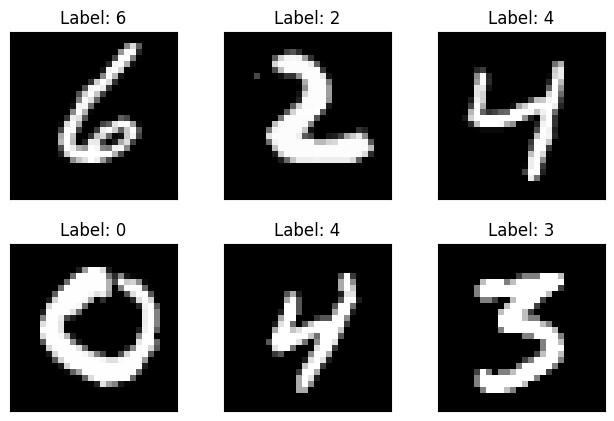

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(data[0][i][0], cmap='gray', interpolation='none')
    plt.title(f'Label: {data[1][i]}')
    plt.xticks([])
    plt.yticks([])

L'entrainement va donc être effectué de manière supervisée : c'est-à-dire que le réseau va faire une prédiction pour chaque image traitée, prédiction qui va ensuite être comparée au *label*. Les paramètres du réseau vont ensuite être automatiquement mis à jour selon si la prédiction est correcte ou non.

**Exercice 3 :** Copiez vos classes `VisionEncoder` et `ViT` conçues lors du TP5. Comme nous allons entrainer le modèle avec des batchs d'une taille supérieure à 1, il est nécessaire d'effectuer une petite gymnastique au niveau du `class_token` dans le modèle `ViT`. En effet, celui-ci est généré de manière aléatoire dans le `__init__` et doit ensuite être le même pour chaque batch. Utilisez la fonction `expand` (https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html) dans le `forward` afin d'étendre le tenseur sur le nombre correct de batchs (`[32, 1, 512]` au lieu de `[1, 1, 512]`).
Deux petites corrections sont à apporter également par rapport à ce qui vous a été indiqué dans le TP précédent :
- `fwd_mlp` doit correspondre à `fwd_attention + self.mlp(fwd_norm2)` au lieu de `fwd_norm2 + self.mlp(fwd_norm2)` dans la partie `forward` de `VisionEncoder`
- Le `.float()` de `img_torch_reshape` dans la partie `forward` de `ViT` peut être retiré

In [ ]:
from TP5_MHA import MultiHeadAttention

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
class VisionEncoder(torch.nn.Module):
    def __init__(self, embed_size, num_heads, hidden_size, dropout):
        super(VisionEncoder, self).__init__()

        self.embed_size = embed_size
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.dropout = dropout

        # Première couche : Linear + LayerNorm
        self.norm1 = torch.nn.LayerNorm(embed_size)
        self.mha = MultiHeadAttention(embed_size, num_heads, dropout)
        self.add_norm = torch.nn.Sequential(
            torch.nn.Linear(embed_size, hidden_size),
            torch.nn.GELU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_size, embed_size),
            torch.nn.Dropout(dropout)
        )

    def forward(self, x):
        # Première couche : Normalisation + Multi-Head Attention + Résiduel
        norm1_output = self.norm1(x)
        mha_output = self.mha(norm1_output, norm1_output, norm1_output)
        add_norm1_output = x + mha_output

        # Deuxième couche : Linear + GELU + Dropout + Linear + Dropout + Résiduel
        mlp_output = self.add_norm(add_norm1_output)
        add_norm2_output = add_norm1_output + mlp_output

        return add_norm2_output

In [ ]:
# class ViT(torch.nn.Module):
    # ...
    # Compléter ici

# model = ViT(image_size=28, channel_size=1, patch_size=7, embed_size=512, nb_heads=8, classes=10, nb_layers=3, hidden_size=256, dropout=0.2).to(device)
# print(model)

In [ ]:
import torch.nn as nn
import torch
import torch.nn as nn

class ViT(nn.Module):
    def __init__(self, image_size, channel_size, patch_size, embed_size, nb_heads, classes, nb_layers, hidden_size, dropout):
        super(ViT, self).__init__()

        # Paramètres
        self.image_size = image_size
        self.channel_size = channel_size
        self.pixels = image_size ** 2 * channel_size

        self.patch_size = patch_size
        self.embed_size = embed_size
        self.nb_patches = (image_size // patch_size) ** 2
        self.pixels_per_patch = channel_size * (patch_size ** 2)
        self.nb_heads = nb_heads
        self.classes = classes
        self.nb_layers = nb_layers
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.dropout_layer = torch.nn.Dropout(p=dropout)

        # Projection linéaire
        self.embeddings = nn.Linear(self.pixels_per_patch, self.embed_size)

        # Class token
        self.class_token = nn.Parameter(torch.randn(1,1,embed_size))

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1,self.nb_patches+1,embed_size))

        # Layers d'encodage
        self.encoders = nn.ModuleList([
            VisionEncoder(embed_size, nb_heads, hidden_size, dropout)
            for _ in range(nb_layers)
        ])

        # Classification
        self.norm = nn.LayerNorm(embed_size)
        self.classifier = nn.Linear(embed_size, classes)

    def forward(self, img_torch):
        b, c, h, w = img_torch.size()
        img_torch_reshape = img_torch.reshape(b, int((h / self.patch_size) * (w / self.patch_size)), c * self.patch_size * self.patch_size)
        fwd_embeddings = self.embeddings(img_torch_reshape)

        b, n, e = fwd_embeddings.size()
        class_tokens = self.class_token.expand(b, 1, e)

        concat = torch.cat((fwd_embeddings, class_tokens), dim=1)

        fwd_concat = concat + self.positional_encoding

        # Layout
        fwd_dropout = self.dropout_layer(fwd_concat)

        # Layers d'encodage
        for encoder in self.encoders:
            fwd_dropout = encoder(fwd_dropout)
        fwd_encodeurs = fwd_dropout

        # Classification
        cls_token = fwd_encodeurs[:, -1, :]
        cls_token = self.norm(cls_token)
        classification = self.classifier(cls_token)
        fwd_softmac = torch.nn.functional.log_softmax(classification, dim=1)
        return fwd_softmac

model = ViT(image_size=28, channel_size=1, patch_size=7, embed_size=512, nb_heads=8, classes=10, nb_layers=3, hidden_size=256, dropout=0.2).to(device)
print(model)

ViT(
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (embeddings): Linear(in_features=49, out_features=512, bias=True)
  (encoders): ModuleList(
    (0-2): 3 x VisionEncoder(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (dropout_layer): Dropout(p=0.2, inplace=False)
        (Q): Linear(in_features=512, out_features=512, bias=True)
        (K): Linear(in_features=512, out_features=512, bias=True)
        (V): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
      (add_norm): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=256, out_features=512, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (classifier): Line

In [ ]:
# class ViT(torch.nn.Module):
    # ...
    # Compléter ici

# model = ViT(image_size=28, channel_size=1, patch_size=7, embed_size=512, nb_heads=8, classes=10, nb_layers=3, hidden_size=256, dropout=0.2).to(device)
# print(model)

Notez bien les paramètres utilisés pour le modèle. Notamment `image_size`, `channel_size` et `patch_size` pour le calcul des patchs, de leur nombre de pixels et donc de la taille en entrée du réseau. Egalement le paramètre `classes` permet de fixer le nombre de sorties possibles à `10` pour le réseau (chaque chiffre entre 0 et 9 !).

Il est à présent nécessaire d'avoir une méthode afin d'évaluer à quel point le modèle parvient à reconnaitre les chiffres du jeu de données (sa précision !). Pour cela on emploie une fonction objectif (*loss function*) qui va tout simplement sortir une grande valeur quand la prédiction est mauvaise, et à l'inverse une petite valeur si la prédiction est bonne. Là encore, de multiples possibilités sont disponibles directement dans PyTorch selon les besoins (https://pytorch.org/docs/stable/nn.html#loss-functions).

**Exercice 4 :** Stockez dans la variable `loss_fct` la fonction objectif `NLLLoss` (aucun paramètre n'est nécessaire). Cette fonction sera ensuite utilisée lors de l'entrainement.

In [ ]:
loss_fct = nn.NLLLoss()
print(loss_fct)

NLLLoss()


In [ ]:
# loss_fct =
# print(loss_fct)

En parallèle, il est également nécessaire d'avoir un algorithme d'optimisation afin de minimiser la fonction objectif que nous venons de définir (pour obtenir la meilleure précision possible !). Pour cela, cette méthode va directement agir sur les paramètres apprenables du modèle en les mettant à jour selon la *loss* (pensez à un technicien qui va progressivement régler une machine afin de produire les meilleurs résultats possibles !). La plupart des méthodes connues sont basées sur l'algorithme de descente de gradient (*gradient descent*), et une fois n'est pas coutume PyTorch nous facilite grandement le travail (https://pytorch.org/docs/stable/optim.html#algorithms).

**Exercice 5 :** Stockez dans la variable `optimizer` l'algorithme `Adam` qui prend en paramètres les paramètres du modèle (`model.parameters()`) et un taux d'apprentissage (*learning rate*) égal à `5e-5` (`0.00005`).

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 5e-05
    maximize: False
    weight_decay: 0
)


In [ ]:
# optimizer =
# print(optimizer)

Il est à présent temps de concevoir la boucle d'entrainement. Comme décrit précédemment, nous allons itérer sur les données du *DataLoader* à l'aide d'une boucle pour obtenir des *batchs* de données. Chaque *batch* va passer dans le réseau conçu et permettre d'obtenir une prédiction. Cette prédiction va ensuite être comparée à la valeur attendue (*labels*) à l'aide de la fonction objectif (*loss function*). Enfin, l'algorithme d'optimisation va mettre à jour les paramètres du modèle selon les résultats obtenus.

**Exercice 6 :** Concevez la boucle d'entrainement en complétant les informations manquantes (remplacer les `???` par votre réponse, aidez-vous de la documentation PyTorch !). Assimilez également les différents éléments utilisés et décrits en commentaires. L'entrainement en lui-même peut prendre plusieurs dizaines de minutes selon la puissance du CPU ou GPU utilisé (conseil : importez le notebook dans Google Colab si vous ne possédez pas de GPU).

In [ ]:
# Liste pour conserver les valeurs de loss (rappel : on souhaite minimiser la valeur de loss)
losses = []

# Liste pour conserver les précisions du modèle (en %)
accuracies = []

# Ces listes permettront d'afficher les courbes de loss et de précision après l'entrainement

# 1 epoch correspond à un passage complet sur l'ensemble des données (les 60000 images !)
# Le modèle va donc voir chaque image 10 fois
nb_epochs = 15

# Boucle permettant de faire nb_epochs passages sur l'ensemble des données
for epoch in range(nb_epochs):

  # Passage du modèle en mode entrainement (certains paramètres agissent différemment selon si il s'agit de la phase d'entrainement ou d'évaluation)
  model.train()

  # Récupération de la loss sur l'epoch
  epoch_loss = 0

  # Liste pour conserver l'ensemble des prédictions faites durant l'epoch actuelle
  y_pred = []

  # Liste pour conserver l'ensemble des valeurs à prédire durant l'epoch actuelle
  y_true = []

  # Boucle permettant de parcourir l'ensemble des données du DataLoader (les 60000 images !)
  # Chaque itération contient 32 images et labels comme défini lors de la création du DataLoader
  for batch_idx, (imgs, labels) in enumerate(train_dataloader):

    # Envoi des données sur le processeur choisi (CPU ou GPU)
    imgs = imgs.to(device)
    labels = labels.to(device)

    # Passage du batch d'images dans le modèle ViT conçu
    # On obtient les prédictions directement en sortie (shape : [32, 10])
    predictions = model(imgs)

    # Calcul de la loss sur le batch
    loss = loss_fct(predictions, labels)

    # Nettoyage des anciens paramètres de mise à jour calculés
    optimizer.zero_grad()

    # Calcul des paramètres du modèle à mettre à jour (rétropropagation du gradient)
    loss.backward()

    # Mise à jour des paramètres du modèle
    optimizer.step()

    # Mise à jour de la loss sur l'epoch
    epoch_loss += loss.item()

    # La variable contient pour chaque image du batch 10 valeurs
    # Chaque valeur correspond à une probabilité pour chacun des chiffres entre 0 et 9
    # L'indice de la probabilité la plus forte correspond au chiffre prédit par le réseau !

    # On ajoute les prédictions et les valeurs à prédire dans les listes correspondantes
    y_pred.extend(torch.argmax(predictions, dim=1).detach().cpu().tolist())
    y_true.extend(labels.detach().tolist())

  # Ajout de la loss de l'epoch à la liste de l'ensemble des loss
  losses.append(epoch_loss)

  # Vérification et calcul de la précision du modèle en comparant pour chaque image son label avec la valeur prédite
  nb_imgs = len(y_pred)
  total_correct = 0
  for i in range(nb_imgs):
    if y_pred[i] == y_true[i]:
      total_correct += 1

  accuracy = total_correct * 100 / nb_imgs

  # Ajout de la précision à la liste des précisions
  accuracies.append(accuracy)

  # Affichage des résultats pour l'epoch en cours (loss et précision)
  print("----------")
  print("Epoch:", epoch)
  print("Loss:", epoch_loss)
  print(f"Accuracy: {accuracy} % ({total_correct} / {nb_imgs})")

----------
Epoch: 0
Loss: 175.75041562924162
Accuracy: 96.96666666666667 % (58180 / 60000)
----------
Epoch: 1
Loss: 168.2927456102334
Accuracy: 97.055 % (58233 / 60000)
----------
Epoch: 2
Loss: 155.0225410494022
Accuracy: 97.29166666666667 % (58375 / 60000)
----------
Epoch: 3
Loss: 147.83811319700908
Accuracy: 97.48 % (58488 / 60000)
----------
Epoch: 4
Loss: 133.52435913449153
Accuracy: 97.64833333333333 % (58589 / 60000)
----------
Epoch: 5
Loss: 125.60619176819455
Accuracy: 97.76666666666667 % (58660 / 60000)
----------
Epoch: 6
Loss: 121.83719390456099
Accuracy: 97.88 % (58728 / 60000)
----------
Epoch: 7
Loss: 113.93623785191448
Accuracy: 98.00666666666666 % (58804 / 60000)
----------
Epoch: 8
Loss: 103.24538530220161
Accuracy: 98.205 % (58923 / 60000)
----------
Epoch: 9
Loss: 106.37168154591927
Accuracy: 98.12166666666667 % (58873 / 60000)
----------
Epoch: 10
Loss: 97.41639831391512
Accuracy: 98.27 % (58962 / 60000)
----------
Epoch: 11
Loss: 91.46106128243264
Accuracy: 98.3

In [ ]:
# Liste pour conserver les valeurs de loss (rappel : on souhaite minimiser la valeur de loss)
losses = []
# Liste pour conserver les précisions du modèle (en %)
accuracies = []
# Ces listes permettront d'afficher les courbes de loss et de précision après l'entrainement

# 1 epoch correspond à un passage complet sur l'ensemble des données (les 60000 images !)
# Le modèle va donc voir chaque image 10 fois
nb_epochs = 10

# Boucle permettant de faire nb_epochs passages sur l'ensemble des données
for epoch in range(nb_epochs):
    # Passage du modèle en mode entrainement (certains paramètres agissent différemment selon si il s'agit de la phase d'entrainement ou d'évaluation)
    model.train() # Compléter ici (indice : c'est une fonction simple sans paramètre)

    # Variable pour stocker la valeur de loss sur l'ensemble de l'epoch
    epoch_loss = 0

    # Liste pour conserver l'ensemble des prédictions faites durant l'epoch actuelle
    y_pred = []
    # Liste pour conserver l'ensemble des valeurs à prédire durant l'epoch actuelle
    y_true = []

    # Boucle permettant de parcourir l'ensemble des données du DataLoader (les 60000 images !)
    # Chaque itération contient 32 images et labels comme défini lors de la création du DataLoader
    for batch_idx, (imgs, labels) in enumerate(train_dataloader):
        # Envoi des données sur le processeur choisi (CPU ou GPU)
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Passage du batch d'images dans le modèle ViT conçu
        # On obtient les prédictions directement en sortie (shape : [32, 10])
        predictions = model(imgs) # Compléter ici (indice : un exemple de passage d'un batch dans le modèle a été donné à la toute fin du TP5)

        # Comparaison des prédictions et des labels à l'aide de la fonction objectif
        loss = loss_fct(predictions, labels) # Compléter ici (indice : vous avez simplement besoin de la fonction objectif définie plus haut, et de 2 paramètres)

        # Nettoyage des anciens paramètres de mise à jour calculés
        optimizer.zero_grad()

        # Calcul des paramètres du modèle à mettre à jour (retropropagation du gradient)
        loss.backward() # Compléter ici (indice : c'est une fonction simple sans paramètre)

        # Mise à jour des paramètres du modèle
        optimizer.step() # Compléter ici (indice : c'est une fonction simple sans paramètre)

        # La variable contient pour chaque image du batch 10 valeurs
        # Chaque valeur correspond à une probabilité pour chacun des chiffres entre 0 et 9
        # L'indice de la probabilité la plus forte correspond au chiffre prédit par le réseau !
        # On ajoute les prédictions et les valeurs à prédire dans les listes correspondantes
        y_pred.extend(predictions.detach().cpu().tolist()) # Compléter ici (indice : on veut l'indice de la valeur maximale des éléments du tenseur pour chaque batch, une fonction PyTorch existe pour cela !)
        y_true.extend(labels.detach().tolist())

        # Ajout de la valeur de loss du batch à la valeur de loss sur l'ensemble de l'epoch
        epoch_loss += loss.item()

    # Ajout de la loss de l'epoch à la liste de l'ensemble des loss
    losses.append(epoch_loss)

    # Vérification et calcul de la précision du modèle en comparant pour chaque image son label avec la valeur prédite
    nb_imgs = len(y_pred)
    total_correct = 0
    for i in range(nb_imgs):
        if y_pred[i] == y_true[i]:
            total_correct += 1
    accuracy = total_correct * 100 / nb_imgs

    # Ajout de la précision à la liste des précisions
    accuracies.append(accuracy)

    # Affichage des résultats pour l'epoch en cours (loss et précision)
    print("----------")
    print("Epoch:", epoch)
    print("Loss:", epoch_loss)
    print(f"Accuracy: {accuracy} % ({total_correct} / {nb_imgs})")

In [ ]:
import torch
import torch.nn as nn

class ViT(nn.Module):
    def __init__(self, image_size, channel_size, patch_size, embed_size, nb_heads, classes, nb_layers, hidden_size, dropout):
        super(ViT, self).__init__()

        # Paramètres
        self.image_size = image_size
        self.channel_size = channel_size
        self.pixels = image_size ** 2 * channel_size

        self.patch_size = patch_size
        self.embed_size = embed_size
        self.nb_patches = (image_size // patch_size) ** 2
        self.pixels_per_patch = channel_size * (patch_size ** 2)
        self.nb_heads = nb_heads
        self.classes = classes
        self.nb_layers = nb_layers
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.dropout_layer = torch.nn.Dropout(p=dropout)

        # Projection linéaire
        self.embeddings = nn.Linear(self.pixels_per_patch, self.embed_size)

        # Class token
        self.class_token = nn.Parameter(torch.randn(1,1,embed_size))

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1,self.nb_patches+1,embed_size))

        # Layers d'encodage
        self.encoders = nn.ModuleList([
            VisionEncoder(embed_size, nb_heads, hidden_size, dropout)
            for _ in range(nb_layers)
        ])

        # Classification
        self.norm = nn.LayerNorm(embed_size)
        self.classifier = nn.Linear(embed_size, classes)

    def forward(self, img_torch):
        b, c, h, w = img_torch.size()
        img_torch_reshape = img_torch.reshape(b, int((h / self.patch_size) * (w / self.patch_size)), c * self.patch_size * self.patch_size).float()
        fwd_embeddings = self.embeddings(img_torch_reshape)

        b, n, e = fwd_embeddings.size()
        class_tokens = self.class_token.expand(b, 1, e)

        concat = torch.cat((fwd_embeddings, class_tokens), dim=1)

        fwd_concat = concat + self.positional_encoding

        # Layout
        fwd_dropout = self.dropout_layer(fwd_concat)

        # Layers d'encodage
        for encoder in self.encoders:
            fwd_dropout = encoder(fwd_dropout)

        # Classification
        cls_token = fwd_dropout[:, 0]
        cls_token = self.norm(cls_token)
        classification = self.classifier(cls_token)

        return classification


model = ViT(image_size=28, channel_size=1, patch_size=7, embed_size=512, nb_heads=8, classes=10, nb_layers=3, hidden_size=256, dropout=0.2)
#print(model)
for batch_idx, (imgs, labels) in enumerate(train_dataloader):
    # Envoi des données sur le processeur choisi (CPU ou GPU)
    imgs = imgs.to(device)
    labels = labels.to(device)
    # Passage du batch d'images dans le modèle ViT conçu
    # On obtient les prédictions directement en sortie (shape : [32, 10])
    #print(imgs.shape)
     # Compléter ici (indice : un exemple de passage d'un batch dans le modèle a été donné à la toute fin du TP5)

    #print(img_torch.shape)
    out = model(img_torch)
    print(out.shape)

A l'issue de la première *epoch* votre modèle devrait déjà parvenir à trouver le chiffre dans environ 75% des cas (ce chiffre peut varier d'un entrainement à l'autre). En poussant l'entrainement sur quelques epochs supplémentaires, il est même possible d'atteindre plus de 97% de précision sur le jeu de données d'entrainement ! Par ailleurs, avec des jeux de données et des problématiques plus complexes, la précision du modèle est généralement beaucoup plus progressive.

On peut à présent faire un `plot` de la loss pour constater que celle-ci descend bien au fil de l'entrainement.

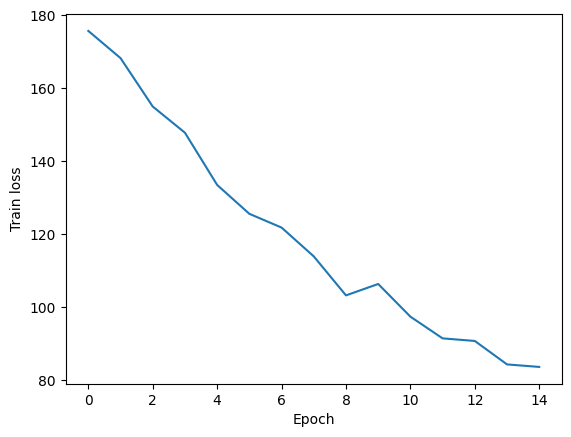

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.show()

De même pour la précision qui monte au fil de l'entrainement.

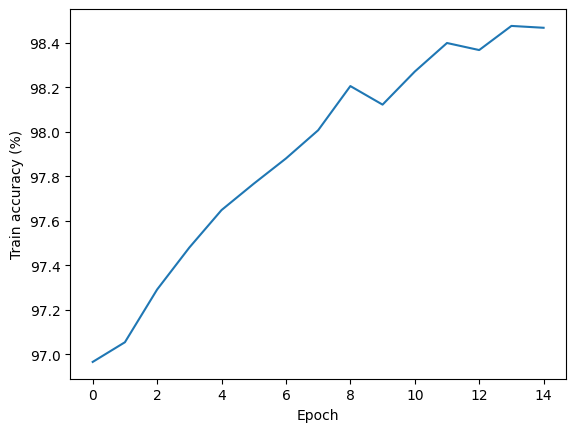

In [ ]:
plt.plot(accuracies)
plt.xlabel("Epoch")
plt.ylabel("Train accuracy (%)")
plt.show()

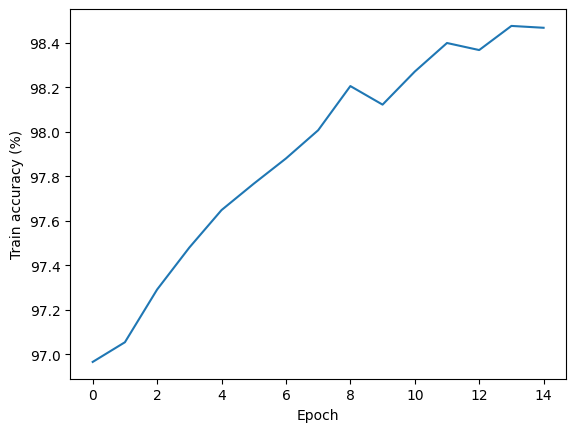

In [ ]:
plt.plot(accuracies)
plt.xlabel("Epoch")
plt.ylabel("Train accuracy (%)")
plt.show()

On peut désormais évaluer notre modèle sur les données du DataLoader de test. Etant donné que ce sont des images que le modèle n'a jamais vu durant son entrainement, c'est un bon moyen de vérifier si il parvient à généraliser la reconnaissance de chiffre à n'importe quelle image MNIST !

**Exercice 7 :** Concevez la boucle d'évaluation en complétant les informations manquantes (remplacer les `???` par votre réponse, aidez-vous de la documentation PyTorch !). Assimilez également les différents éléments utilisés et décrits en commentaires. Constatez également que l'on ne fait pas appel aux fonctions de mise à jour du modèle ici, on souhaite juste évaluer sa précision réelle.

In [ ]:
# Permet de s'assurer qu'aucun paramètre du modèle ne sera mis à jour
with torch.no_grad():
    # Permet d'avertir le modèle qu'il s'agit de la phase d'évaluation
    # Certains paramètres agissent différemment selon si il s'agit de la phase d'entrainement ou d'évaluation
    model.??? # Compléter ici (indice : c'est une fonction simple sans paramètre)

    # Liste pour conserver l'ensemble des prédictions faites
    y_test_pred = []
    # Liste pour conserver l'ensemble des valeurs à prédire
    y_test_true = []

    # Boucle permettant de parcourir l'ensemble des données du DataLoader de test (les 10000 images !)
    for batch_idx, (imgs, labels) in enumerate(test_dataloader):
        # Envoi des données sur le processeur choisi (CPU ou GPU)
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Passage du batch d'images dans le modèle ViT conçu
        # On obtient les prédictions directement en sortie
        predictions = ??? # Compléter ici (indice : un exemple de passage d'un batch dans le modèle a été donné à la toute fin du TP5)

        # La variable contient pour chaque image du batch 10 valeurs
        # Chaque valeur correspond à une probabilité pour chacun des chiffres entre 0 et 9
        # L'indice de la probabilité la plus forte correspond au chiffre prédit par le réseau !
        # On ajoute les prédictions et les valeurs à prédire dans les listes correspondantes
        y_test_pred.extend(predictions.detach().???.tolist()) # Compléter ici (indice : on veut l'indice de la valeur maximale des éléments du tenseur pour chaque batch, une fonction PyTorch existe pour cela !)
        y_test_true.extend(labels.detach().tolist())

    # Vérification et calcul de la précision du modèle en comparant pour chaque image son label avec la valeur prédite
    nb_imgs = len(y_test_pred)
    total_correct = 0
    for i in range(nb_imgs):
        if y_test_pred[i] == y_test_true[i]:
            total_correct += 1
    accuracy = total_correct * 100 / nb_imgs

    # Affichage du résultat de précision sur le jeu de données d'évaluation
    print(f"Evaluation accuracy: {accuracy} % ({total_correct} / {nb_imgs})")


In [ ]:
with torch.no_grad():
  model.eval()

  y_test_pred = []
  y_test_true = []

  for batch_idx, (imgs, labels) in enumerate(test_dataloader):
    imgs = imgs.to(device)
    labels = labels.to(device)

    predictions = model(imgs)

    y_test_pred.extend(predictions.detach().argmax(dim=1).tolist())
    y_test_true.extend(labels.detach().tolist())

nb_imgs = len(y_test_pred)
total_correct = 0
for i in range(nb_imgs):
  if y_test_pred[i] == y_test_true[i]:
    total_correct += 1

accuracy = total_correct * 100 / nb_imgs

print(f"Evaluation accuracy: {accuracy} % ({total_correct} / {nb_imgs})")

Evaluation accuracy: 98.12 % (9812 / 10000)


In [ ]:
torch.save(model.state_dict(), 'tp6-entrainement.pth')